In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc
import mindspore
from mindspore import nn, ops, Tensor
from mindspore.train import Model
import mindspore.numpy as mnp
from mindspore.common.initializer import initializer, XavierUniform
import os
from mindcos.operators.derivatives import grad

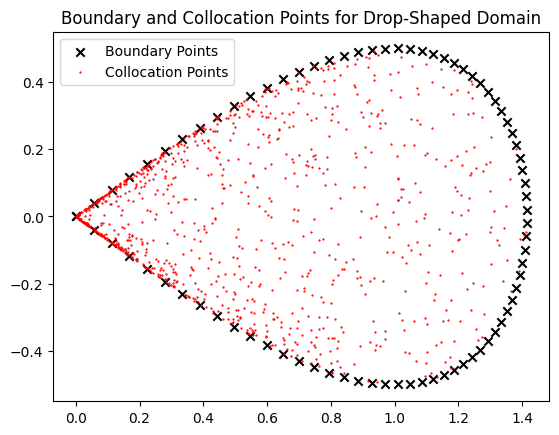

In [3]:
# .......................................................................
# 英文: Solve the Grad-Shafranov equation for Soloviev equilibria, parametrized
# following Deriaz et al. paper. This models a drop-shaped plasma equilibrium.
# 中文: 求解基于Deriaz等人论文参数化的Soloviev平衡的Grad-Shafranov方程，
# 该模型描述了一个滴状等离子体平衡。
# .......................................................................

# 英文: Data generation on the boundary for the drop-shaped contour
# 中文: 在滴状轮廓边界上生成数据
# 英文: The boundary points and collocation points are generated for solving
# the Grad-Shafranov equation, which is used to model plasma equilibrium in 
# accretion disks or tokamaks. These points define the computational domain.
# 中文: 为求解Grad-Shafranov方程生成边界点和配点，用于模拟吸积盘或托卡马克中的等离子体平衡。
# 这些点定义了计算域。
n_bc = 1  # 英文: Number of boundary conditions / 中文: 边界条件数量
n_data_per_bc = 80  # 英文: Number of data points per boundary / 中文: 每个边界的数据点数量
theta = np.linspace(np.pi, 3 * np.pi, n_data_per_bc)  # 英文: Angular coordinates for boundary points / 中文: 边界点的角度坐标
pa = 0.5  # 英文: Parameter controlling the drop shape / 中文: 控制滴状轮廓的参数

# 英文: Parametric equations for the drop-shaped boundary
# 中文: 滴状边界的参数方程
x = np.sqrt(1 + 2 * pa * np.cos(theta))
y = pa * np.sin(theta)

# 英文: Store boundary data (x, y, value=0 for Dirichlet condition)
# 中文: 存储边界数据（x, y，Dirichlet条件的数值=0）
data = np.zeros([n_bc, n_data_per_bc, 3])
data[0, :, 0] = x
data[0, :, 1] = y
data[0, :, 2] = 0
data = data.reshape(n_data_per_bc * n_bc, 3)  # 英文: Reshape to [n_bc * n_data_per_bc, 3] / 中文: 重塑为[n_bc * n_data_per_bc, 3]

# 英文: Expand dimensions for x, y, and boundary condition values
# 中文: 为x、y和边界条件值扩展维度
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), [data[:, 0], data[:, 1], data[:, 2]])

# 英文: Generate collocation points for the PDE residual using Latin Hypercube Sampling
# 中文: 使用拉丁超立方采样生成PDE残差的配点
# 英文: These points are distributed within the domain and used to enforce the PDE.
# 中文: 这些点分布在计算域内，用于强制满足PDE。
Nc = 1000  # 英文: Number of collocation points / 中文: 配点数量
colloc = np.zeros([Nc, 2])
engine = qmc.LatinHypercube(d=2)  # 英文: Initialize Latin Hypercube sampler / 中文: 初始化拉丁超立方采样器
points = engine.random(n=Nc)  # 英文: Generate random points / 中文: 生成随机点

# 英文: Transform points to fit the drop-shaped domain
# 中文: 转换点以适应滴状计算域
points[:, 0] = (points[:, 0] * 2 * np.pi + np.pi)  # 英文: Scale angular coordinate / 中文: 缩放角度坐标
# 英文: The power (0.75) localizes points; can be tuned for distribution
# 中文: 幂次（0.75）用于局部化点分布，可调整以改变分布
colloc[:, 0] = points[:, 1] ** 0.75 * np.sqrt(1 + np.cos(points[:, 0]))
colloc[:, 1] = points[:, 1] ** 0.75 * pa * np.sin(points[:, 0])

# 英文: Expand dimensions for collocation points
# 中文: 为配点扩展维度
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), [colloc[:, 0], colloc[:, 1]])

# 英文: Visualize boundary and collocation points
# 中文: 可视化边界点和配点
plt.title("Boundary and Collocation Points for Drop-Shaped Domain")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="Boundary Points")
plt.scatter(colloc[:, 0], colloc[:, 1], s=1.5, marker=".", c="r", label="Collocation Points")
plt.legend()
plt.savefig('boundary_and_collocation_points.png')  # 英文: Save as descriptive filename / 中文: 保存为描述性文件名
plt.show()
plt.close()

# 英文: Convert data to MindSpore tensors
# 中文: 将数据转换为MindSpore张量
x_c, y_c, x_d, y_d, t_d = map(lambda x: Tensor(x, dtype=mindspore.float32), [x_c, y_c, x_d, y_d, t_d])

In [6]:
# 英文: Define the Deep Neural Network (DNN) for the PINN
# 中文: 定义用于PINN的深度神经网络（DNN）
class DNN(nn.Cell):
    def __init__(self, in_shape=2, out_shape=1, n_hidden_layers=7, neuron_per_layer=20):
        super(DNN, self).__init__()
        self.layers = nn.SequentialCell()
        # 英文: Add input layer to first hidden layer / 中文: 添加输入层到第一个隐藏层
        self.layers.append(nn.Dense(in_shape, neuron_per_layer))
        # 英文: Add activation function / 中文: 添加激活函数
        self.layers.append(nn.Tanh())
        # 英文: Add remaining hidden layers / 中文: 添加剩余的隐藏层
        for _ in range(n_hidden_layers - 1):
            self.layers.append(nn.Dense(neuron_per_layer, neuron_per_layer))
            self.layers.append(nn.Tanh())
        # 英文: Add output layer / 中文: 添加输出层
        self.layers.append(nn.Dense(neuron_per_layer, out_shape))

    def construct(self, x, y):
        inputs = ops.Concat(axis=1)((x, y))  # 英文: Concatenate inputs / 中文: 拼接输入
        t = self.layers(inputs)
        return t

# 英文: Build the DNN model with specified architecture
# 中文: 使用指定架构构建DNN模型
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=5, neuron_per_layer=32):
    model = DNN(in_shape, out_shape, n_hidden_layers, neuron_per_layer)
    return model

# 英文: Define the loss function for the Physics-Informed Neural Network (PINN)
# 中文: 定义物理信息神经网络（PINN）的损失函数
class Loss(nn.Cell):
    def __init__(self):
        super(Loss, self).__init__()

    def mse(self, u, t):
        # 英文: Compute Mean Squared Error / 中文: 计算均方误差
        return ops.ReduceMean()(ops.Square()(u - t))

    def pde_loss(self, model, x_c, y_c):
        x = x_c
        y = y_c
        # 英文: Compute first and second derivatives for the PDE
        # 中文: 计算PDE的一阶和二阶导数
        du_dx_fn = grad(model, 0, 0)
        du2_dx2_fn = grad(du_dx_fn, 0, 0)
        du_dx = du_dx_fn(x, y)
        du2_dx2 = du2_dx2_fn(x, y)
        del du2_dx2_fn, du_dx_fn
        du2_dy2_fn = grad(grad(model, 0, 1), 0, 1)
        du2_dy2 = du2_dy2_fn(x, y)
        del du2_dy2_fn
        # 英文: Grad-Shafranov PDE residual / 中文: Grad-Shafranov PDE残差
        F = x * du2_dx2 + x * du2_dy2 - du_dx + x * (x * x + 1)
        return ops.ReduceMean()(ops.Square()(F))

    def construct(self, model, xc, yc, xd, yd, t):
        u = model(xd, yd)
        loss_mse = self.mse(u, t)  # 英文: Boundary condition loss / 中文: 边界条件损失
        loss_pde = self.pde_loss(model, xc, yc)  # 英文: PDE residual loss / 中文: PDE残差损失
        loss = loss_mse + loss_pde  # 英文: Total loss / 中文: 总损失
        return loss

# 英文: Initialize network, optimizer, and loss function
# 中文: 初始化网络、优化器和损失函数
network = DNN_builder(2, 1, 7, 20)
optimizer = nn.optim.AdamWeightDecay(network.trainable_params(), learning_rate=3e-4)
loss_fn = Loss()

# 英文: Define forward function for gradient computation
# 中文: 定义用于梯度计算的前向函数
def forward_fn(xc, yc, xd, yd, t):
    loss = loss_fn(network, xc, yc, xd, yd, t)
    return loss

# 英文: Compute gradients and update parameters
# 中文: 计算梯度并更新参数
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

def train_step(xc, yc, xd, yd, t):
    (loss), grads = grad_fn(xc, yc, xd, yd, t)
    optimizer(grads)
    return loss

# 英文: Training loop
# 中文: 训练循环
def train_loop(model, xc, yc, xd, yd, t):
    model.set_train()
    loss = train_step(xc, yc, xd, yd, t)
    return loss

# 英文: Testing loop to evaluate loss
# 中文: 测试循环以评估损失
def test_loop(model, xd, yd, t):
    model.set_train(False)
    pred = model(xd, yd)
    loss_test = loss_fn.mse(pred, t)
    return loss_test


[WARNING] DEVICE(149847,ffff80e02020,python):2025-08-03-00:27:52.705.325 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_vmm_adapter.h:149] CheckVmmDriverVersion] Open file /etc/ascend_install.info failed.
[WARNING] DEVICE(149847,ffff80e02020,python):2025-08-03-00:27:52.705.404 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_vmm_adapter.h:177] CheckVmmDriverVersion] Open file /usr/local/Ascend/driver/version.info failed.


Current device target: Ascend
Epoch 1 1.686279, 7.2
-------------------------------
New best model found at epoch 0
Epoch 101 0.207813, 58.1
-------------------------------
New best model found at epoch 100
Epoch 201 0.066027015, 108.7
-------------------------------
New best model found at epoch 200
Epoch 301 0.016994445, 160.2
-------------------------------
New best model found at epoch 300
Epoch 401 0.006367526, 211.5
-------------------------------
New best model found at epoch 400
Epoch 501 0.00490491, 263.5
-------------------------------
New best model found at epoch 500
Epoch 601 0.00418323, 314.9
-------------------------------
New best model found at epoch 600
Epoch 701 0.003571546, 366.6
-------------------------------
New best model found at epoch 700
Epoch 801 0.0030305139, 418.6
-------------------------------
New best model found at epoch 800
Epoch 901 0.0025448508, 470.2
-------------------------------
New best model found at epoch 900
Epoch 1001 0.002107279, 522.8
---

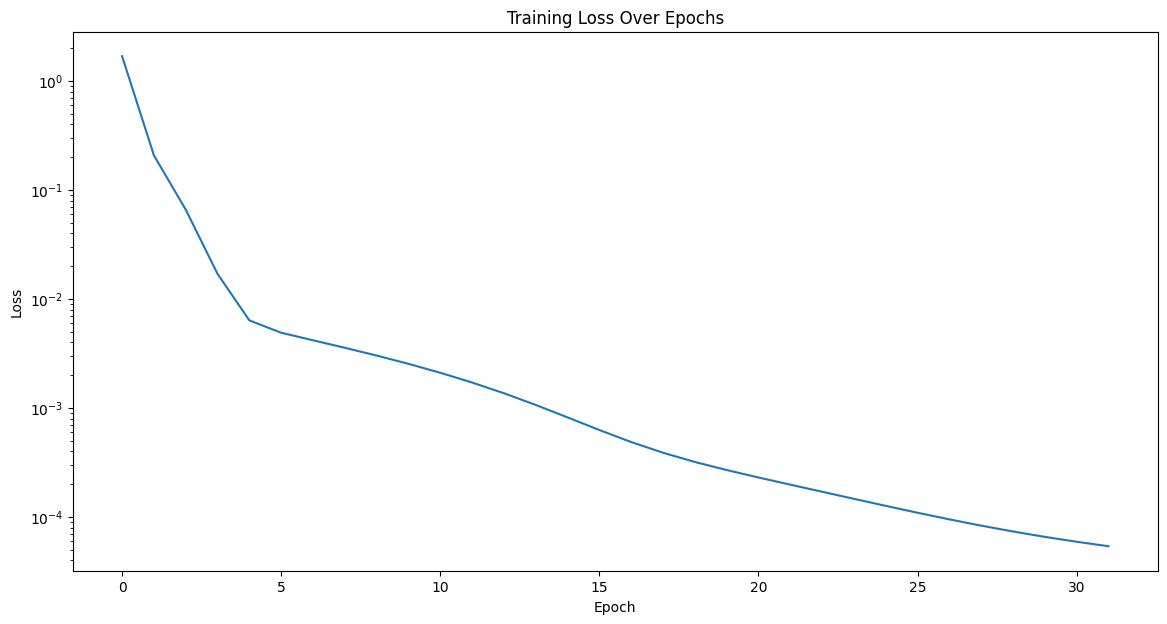

In [7]:
# 英文: Check device target (CPU/GPU/Ascend)
# 中文: 检查设备目标（CPU/GPU/Ascend）
device_target = mindspore.context.get_context("device_target")
print("Current device target:", device_target)

# 英文: Initialize training parameters
# 中文: 初始化训练参数
loss = 0
epochs = 5000
epoch = 0
loss_values = np.array([])  # 英文: Store total loss / 中文: 存储总损失
log_dir = './log/GradS_drop'
os.makedirs(log_dir, exist_ok=True)
with open(f'{log_dir}/train.log', 'a') as f:
    f.write('\nepoch, loss, time\n')

# 英文: Start training and track best model
# 中文: 开始训练并跟踪最佳模型
start = time.time()
loss_test = 1e9
best_network = None

for epoch in range(epochs):
    loss = train_loop(network, x_c, y_c, x_d, y_d, t_d)
    if epoch % 100 == 0 or epoch == epochs - 1:
        loss_values = np.append(loss_values, loss)
        print(f"Epoch {epoch + 1} {loss}, {time.time() - start:.1f}\n-------------------------------")
        with open(f'{log_dir}/train.log', 'a') as f:
            f.write(f'{epoch + 1}, {loss}, {time.time() - start:.1f}\n')
        _loss_test = test_loop(network, x_d, y_d, t_d)
        if loss_test > _loss_test:
            print(f'New best model found at epoch {epoch}')
            best_network = network
    if loss < 5e-5:
        break

# 英文: Record computation time
# 中文: 记录计算时间
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\nComputation time: {end - start:.3f}\n")

# 英文: Plot loss curve
# 中文: 绘制损失曲线
plt.figure(figsize=(14, 7))
plt.semilogy(loss_values)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('training_loss_curve.png')  # 英文: Save as descriptive filename / 中文: 保存为描述性文件名
plt.show()
plt.close()

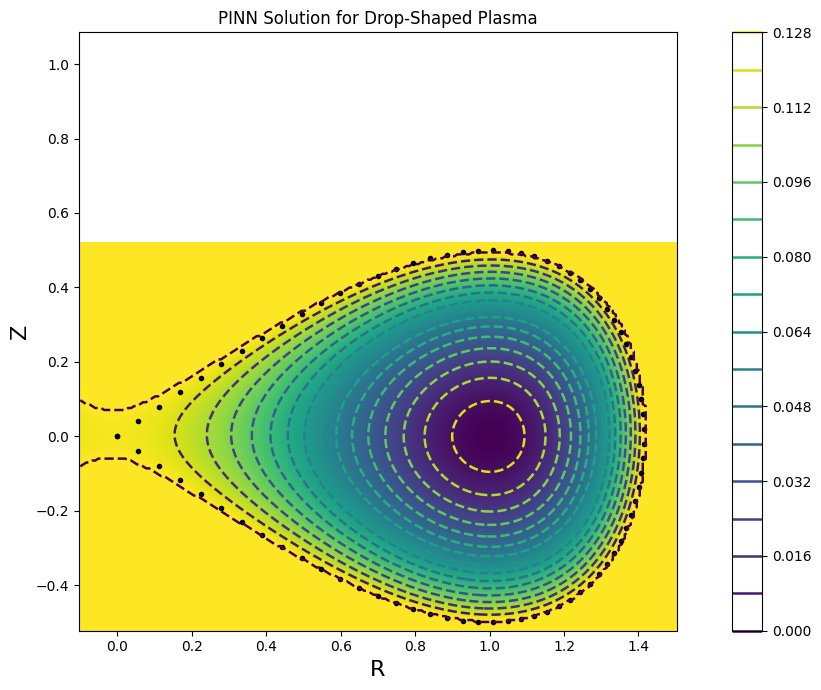

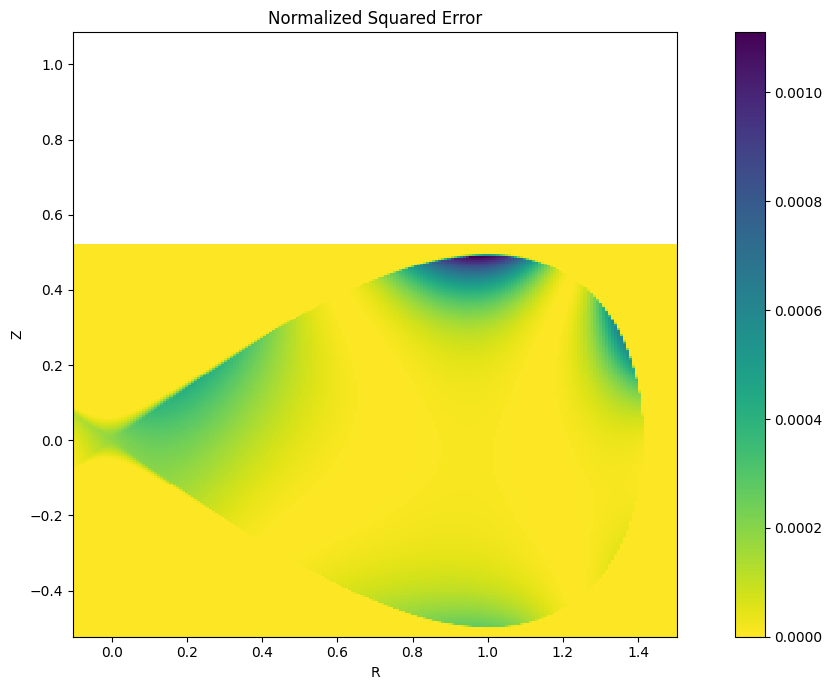

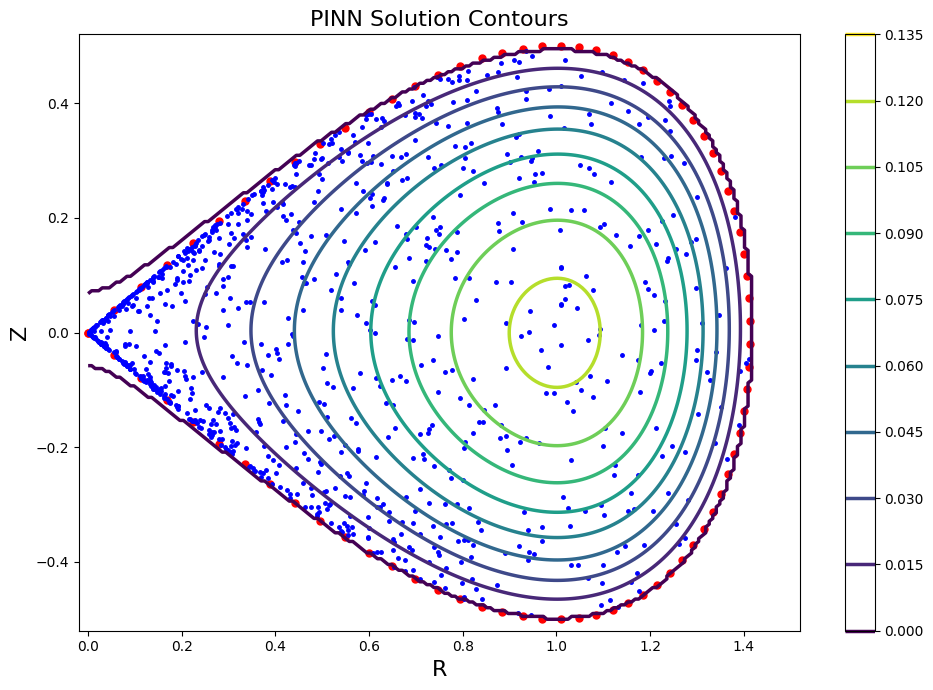

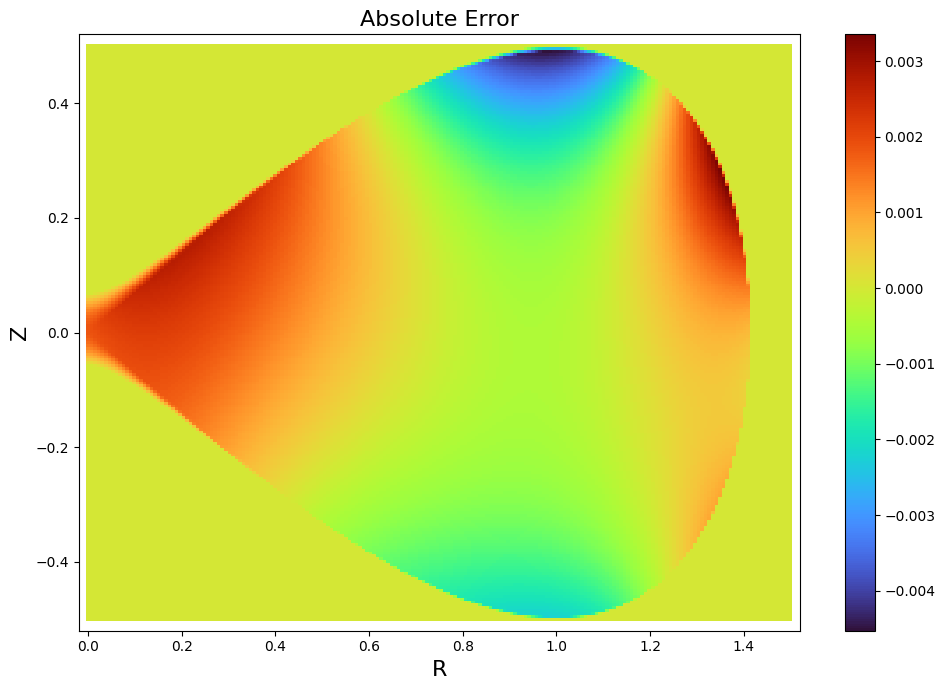

In [9]:
# 英文: Use best network for inference
# 中文: 使用最佳网络进行推理
best_network.set_train(False)

# 英文: Generate grid for visualization
# 中文: 生成用于可视化的网格
n = 200
l = 1.
r = 2 * l / (n + 1)
T = np.zeros([n * n, n * n])

# 英文: Plot PINN solution
# 中文: 绘制PINN解
plt.figure(figsize=(14, 7))
X = np.linspace(-0.1, 1.5, n)
Y = np.linspace(-0.52, 0.52, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n * n, 1])
Y = Y0.reshape([n * n, 1])
X_T = Tensor(X, dtype=mindspore.float32)
Y_T = Tensor(Y, dtype=mindspore.float32)

# 英文: Compute predicted solution
# 中文: 计算预测解
S = best_network(X_T, Y_T)
S = S.numpy().reshape(n, n)
S2 = S
S2[S2 < 0] = 0.0  # 英文: Set negative values to zero / 中文: 将负值设为零
plt.pcolormesh(X0, Y0, S2, cmap="viridis_r")
plt.contour(X0, Y0, S2, 15, linestyles='dashed', linewidths=1.8)
plt.colorbar(pad=-0.25)
plt.scatter(data[:, 0], data[:, 1], marker=".", c="k", label="Boundary Points")
plt.xlabel("R", fontsize=16)
plt.ylabel("Z", fontsize=16)
plt.xlim(-0.1, 1.6)
plt.ylim(-0.52, 0.52)
plt.title("PINN Solution for Drop-Shaped Plasma")
plt.tight_layout()
plt.axis("square")
plt.savefig('pinn_solution.png')  # 英文: Save as descriptive filename / 中文: 保存为描述性文件名
plt.show()
plt.close()

# 英文: Plot exact solution and error
# 中文: 绘制精确解和误差
plt.figure(figsize=(14, 7))
TT = 1 / 8 * (1 - 4 * Y0 ** 2 - (2 * (X0 - 1) + (X0 - 1) ** 2) ** 2)
TT2 = TT
TT2[TT2 < 0] = 0.0
err = (TT2 - S2) ** 2 / 0.135 ** 2
plt.pcolormesh(X0, Y0, err, cmap="viridis_r")
plt.colorbar(pad=-0.25)
plt.xlabel("R")
plt.ylabel("Z")
plt.xlim(0., 1.5)
plt.ylim(-0.5, 0.5)
plt.title("Normalized Squared Error")
plt.tight_layout()
plt.axis("square")
plt.savefig('normalized_error.png')  # 英文: Save as descriptive filename / 中文: 保存为描述性文件名
plt.show()
plt.close()

# 英文: Plot PINN solution with contours and points
# 中文: 绘制带轮廓和点的PINN解
plt.figure(figsize=(10, 7))
X = np.linspace(-0., 1.5, n)
Y = np.linspace(-0.5, 0.5, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n * n, 1])
Y = Y0.reshape([n * n, 1])
X_T = Tensor(X, dtype=mindspore.float32)
Y_T = Tensor(Y, dtype=mindspore.float32)
S = best_network(X_T, Y_T)
S = S.numpy().reshape(n, n)
S2 = S
S2[S2 < 0] = 0.0
plt.contour(X0, Y0, S2, 10, linewidths=2.5)
plt.colorbar(pad=0.05)
plt.scatter(data[:, 0], data[:, 1], marker=".", c="r", s=100, label="Boundary Points")
plt.scatter(colloc[:, 0], colloc[:, 1], s=25, marker=".", c="b", label="Collocation Points")
plt.xlabel("R", fontsize=16)
plt.ylabel("Z", fontsize=16)
plt.xlim(-0.02, 1.52)
plt.ylim(-0.52, 0.52)
plt.title("PINN Solution Contours", fontsize=16)
plt.tight_layout()
plt.savefig('pinn_solution_contours.png')  # 英文: Save as descriptive filename / 中文: 保存为描述性文件名
plt.show()
plt.close()

# 英文: Plot absolute error
# 中文: 绘制绝对误差
plt.figure(figsize=(10, 7))
TT = 1 / 8 * (1 - 4 * Y0 ** 2 - (2 * (X0 - 1) + (X0 - 1) ** 2) ** 2)
TT2 = TT
TT2[TT2 < 0] = 0.0
err = S2 - TT2
plt.pcolormesh(X0, Y0, err, cmap="turbo")
plt.colorbar(pad=0.05)
plt.xlabel("R", fontsize=16)
plt.ylabel("Z", fontsize=16)
plt.xlim(-0.02, 1.52)
plt.ylim(-0.52, 0.52)
plt.title("Absolute Error", fontsize=16)
plt.tight_layout()
plt.savefig('absolute_error.png')  # 英文: Save as descriptive filename / 中文: 保存为描述性文件名
plt.show()
plt.close()